In [1]:
from lmfit import minimize, Parameters
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
covid_df = pd.read_csv("./data/states.csv")
covid_df=covid_df[covid_df['State']=='India'].reset_index(drop = True)
covid_df
omicron_df = covid_df
#omicron_df = covid_df[covid_df['Date']>='2021-12-01'].reset_index(drop = True)
omicron_df['new_cases'] = omicron_df['Confirmed'].shift(1)
omicron_df['new_cases'] = omicron_df['Confirmed'] - omicron_df['new_cases']
omicron_df
omicron_df['new_deaths'] = omicron_df['Deceased'].shift(1)
omicron_df['new_deaths'] = omicron_df['Deceased'] - omicron_df['new_deaths']
omicron_df
delta_df = omicron_df.iloc[350:].reset_index(drop = True)
delta_df

,Date,State,Confirmed,Recovered,Deceased,Other,Tested,new_cases,new_deaths
0,2021-02-11,India,10880439,10587376,155485,4499,204789784.0,9353.0,85.0
1,2021-02-12,India,10892576,10598734,155589,4503,205533398.0,12137.0,104.0
2,2021-02-13,India,10904774,10609841,155678,4521,206230512.0,12198.0,89.0
3,2021-02-14,India,10916480,10619341,155769,4527,206716634.0,11706.0,91.0
4,2021-02-15,India,10925566,10631134,155851,4549,207332298.0,9086.0,82.0
...,...,...,...,...,...,...,...,...,...
258,2021-10-27,India,34231243,33606777,456418,13182,604498405.0,16351.0,734.0
259,2021-10-28,India,34245550,33619966,457223,13187,605885769.0,14307.0,805.0
260,2021-10-29,India,34259765,33633515,457774,13195,607062619.0,14215.0,551.0
261,2021-10-30,India,34272705,33648187,458219,13196,608319915.0,12940.0,445.0


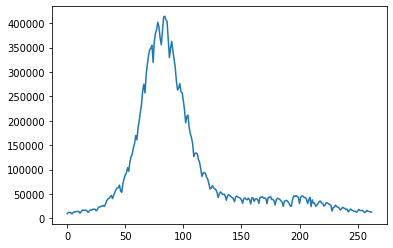

In [3]:
plt.plot(delta_df['new_cases'])

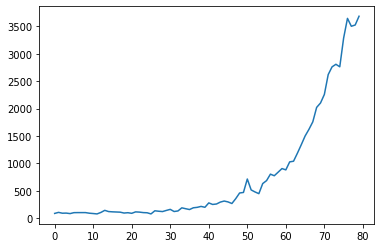

In [4]:
plt.plot(delta_df['new_deaths'][:80])

In [5]:
val = delta_df.iloc[0]['Deceased']
delta_df['cum_deaths'] = delta_df['Deceased'] - val


In [6]:
initial_pop = 1000000000 - delta_df.iloc[0]['Confirmed'] + delta_df.iloc[0]['Recovered'] + delta_df.iloc[0]['Deceased']
initial_pop

999862422

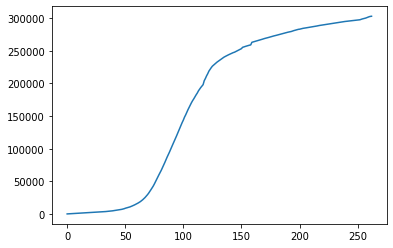

In [7]:
plt.plot(delta_df.cum_deaths)

In [8]:
def get_update_seir(vals,params,dt):
    N,S,E,I,R,D = vals
    mu,alpha,beta,gamma,epsilon= params
    br = mu*N

    Snew = S + dt * (br - (mu*S) - (beta*S*I/N))
    Enew = E + dt * ((beta*S*I/N) - (mu + epsilon)*E)
    Inew = I + dt * (epsilon*E - (gamma + mu + alpha)*I)
    Rnew = R + dt * (gamma*I - mu*R)
    Dnew = D + dt * (mu*(S+I+E+R) + alpha*I)

    return (Snew,Enew,Inew,Rnew,Dnew)

def run_seir(initial, params,T,dt):
    N,S,E,I,R,D = initial
    num_steps = T/dt

    for i in range(int(num_steps)):
        temp = (N[-1],S[-1],E[-1],I[-1],R[-1],D[-1])
        Snew,Enew,Inew,Rnew,Dnew = get_update_seir(temp,params,dt)
        Nnew = Snew+Enew+Inew+Rnew
        N.append(Nnew)
        S.append(Snew)
        E.append(Enew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    return N,S,E,I,R,D

In [9]:
N0 = initial_pop
E0 = 20000.0
I0 = 1.0
R0 = 0
S0 = N0 - E0 - I0
D0 = 0
V0 = 0

T = 100
dt = 0.01

mu = 0
alpha = 0.006
beta = 0.75
gamma = 1/8
epsilon = 0.2

In [10]:
initials = [[N0],[S0],[E0],[I0],[R0],[D0]]
params = [mu,alpha,beta,gamma,epsilon]
N_30,S_30,E_30,I_30,R_30,D_30 = run_seir(initials,params,100,1)

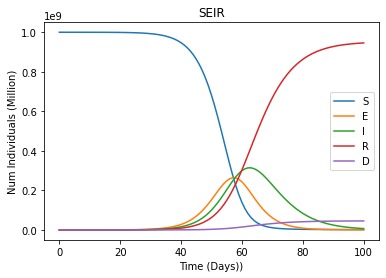

In [11]:
#plt.plot(N, label = 'N')
plt.plot(S_30, label = 'S')
plt.plot(E_30, label = 'E')
plt.plot(I_30, label = 'I')
plt.plot(R_30, label = 'R')
plt.plot(D_30, label = 'D')
plt.title("SEIR")
plt.xlabel("Time (Days))")
plt.ylabel("Num Individuals (Million)")
plt.legend()
#plt.savefig("./Figures/SEIR.png", dpi = 600)

In [12]:
def seir(x, epsilon, gamma, alpha,beta,E0):
    N0 = initial_pop
    I0 = 3
    R0 = 0
    S0 = N0 - E0 - I0
    D0 = 0
    V0 = 0

    T = x
    dt = 1
    mu = 0
    initials = [[N0],[S0],[E0],[I0],[R0],[D0]]
    params = [mu,alpha,beta,gamma,epsilon]
    N,S,E,I,R,D = run_seir(initials,params,60,1)

    
    return D

    

In [13]:
from lmfit import Model, Parameter, report_fit

In [14]:
delta_df

,Date,State,Confirmed,Recovered,Deceased,Other,Tested,new_cases,new_deaths,cum_deaths
0,2021-02-11,India,10880439,10587376,155485,4499,204789784.0,9353.0,85.0,0
1,2021-02-12,India,10892576,10598734,155589,4503,205533398.0,12137.0,104.0,104
2,2021-02-13,India,10904774,10609841,155678,4521,206230512.0,12198.0,89.0,193
3,2021-02-14,India,10916480,10619341,155769,4527,206716634.0,11706.0,91.0,284
4,2021-02-15,India,10925566,10631134,155851,4549,207332298.0,9086.0,82.0,366
...,...,...,...,...,...,...,...,...,...,...
258,2021-10-27,India,34231243,33606777,456418,13182,604498405.0,16351.0,734.0,300933
259,2021-10-28,India,34245550,33619966,457223,13187,605885769.0,14307.0,805.0,301738
260,2021-10-29,India,34259765,33633515,457774,13195,607062619.0,14215.0,551.0,302289
261,2021-10-30,India,34272705,33648187,458219,13196,608319915.0,12940.0,445.0,302734


Text(0.5, 0, 'Time (Days)')

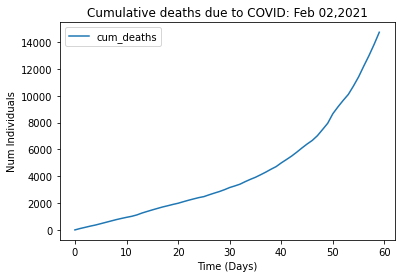

In [15]:
plt.plot(delta_df.cum_deaths[0:60], label = "cum_deaths")
plt.title("Cumulative deaths due to COVID: Feb 02,2021")
plt.legend()
plt.ylabel("Num Individuals")
plt.xlabel("Time (Days)")
#plt.savefig("./Figures/Cum_deaths.png", dpi = 600)

In [16]:
mod = Model(seir)

In [17]:
x = [x for x in range(61)]
y_val = list(delta_df.cum_deaths)[0:61]


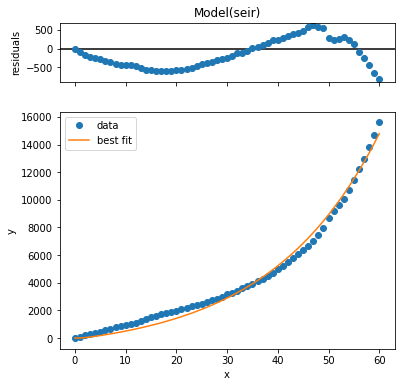

In [18]:
result = mod.fit(y_val, x = x,
    epsilon=Parameter('epsilon', value=1/3, vary = False),
    gamma=Parameter('gamma', value=1/5, vary=False),
    alpha=Parameter('alpha', value=0.006, vary=False, min = 0.006, max = 0.2),
    beta=Parameter('beta', value=0.25, vary=True, min = 0.25, max = 0.95),
    E0=Parameter('E0', value=1, vary=True, min = 0, max = 30000))

fig = result.plot()

In [19]:
#fig.savefig("./Figures/fit.png", dpi = 600)

In [20]:
result.best_values

{'epsilon': 0.3333333333333333,
 'gamma': 0.2,
 'alpha': 0.006,
 'beta': 0.28926321378346553,
 'E0': 14862.248730698628}

In [21]:
N0 = initial_pop
I0 = 3.0
E0 = result.best_values['E0']
R0 = 0
S0 = N0 - E0 - I0
D0 = 0
V0 = 0

epsilon, gamma = result.best_values['epsilon'],result.best_values['gamma']
alpha, beta = result.best_values['alpha'],result.best_values['beta']
mu = 0
initials = [[N0],[S0],[E0],[I0],[R0],[D0]]
params = [mu,alpha,beta,gamma,epsilon]
N,S,E,I,R,D = run_seir(initials,params,60,1)

In [22]:
delta_df['cum_confirmed'] = delta_df['Confirmed'] - delta_df.iloc[0]['Confirmed']

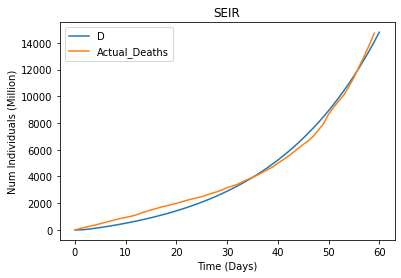

In [23]:
#plt.plot(N, label = 'N')
#plt.plot(S, label = 'S')
#plt.plot(E, label = 'E')
plt.plot(D, label = 'D')
plt.plot(delta_df.cum_deaths[0:60], label = 'Actual_Deaths')
#plt.plot(R, label = 'R')
plt.title("SEIR")
plt.xlabel("Time (Days)")
plt.ylabel("Num Individuals (Million)")
plt.legend()
#plt.savefig("./Figures/SEIR_D_Fit.png", dpi = 600)

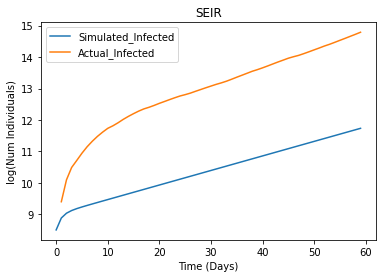

In [24]:
#plt.plot(N, label = 'N')
#plt.plot(S, label = 'S')
#plt.plot(E, label = 'E')
plt.plot(np.log(I[1:]), label = 'Simulated_Infected')
plt.plot(np.log(delta_df.cum_confirmed[1:60]), label = 'Actual_Infected')
#plt.plot(R, label = 'R')
plt.title("SEIR")
plt.xlabel("Time (Days)")
plt.ylabel("log(Num Individuals)")
plt.legend()
#plt.savefig("./Figures/SEIR_I_fit.png", dpi = 600)